## Imports

In [69]:
import gc
from importlib import reload
import logging
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from torch.nn import *
from torch.optim import Adam
from tqdm import tqdm

reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.INFO, datefmt='%I:%M:%S')

## Neural Network Classes

In [70]:
class SimpleCNN(Module):
    def __init__(self, img_dim, classes, config):
        super(SimpleCNN, self).__init__()

        self.layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Flatten(start_dim=1),
            Linear(img_dim * 7, math.floor(img_dim * 7 / 2)),
            Linear(math.floor(img_dim * 7 / 2), classes)
        )
        logging.info(self.layers)

    def forward(self, x):
        x = self.layers(x)
        return x


class DensePolyNN(Module):
    def __init__(self, img_dim, classes, config):
        super(DensePolyNN, self).__init__()
        linear_layers = [
            Linear(
                max(math.floor(img_dim ** 2 / 2 ** depth), 1),
                max(math.floor(img_dim ** 2 / 2 ** (depth + 1)), 1))
            for depth in range(config['nr_linear_layers'] - 1)
        ]
        self.layers = Sequential(
            Flatten(start_dim=1),
            *linear_layers,
            Linear(max(math.floor(img_dim ** 2 / 2 ** (config['nr_linear_layers'] - 1)), 1), classes)
        )
        logging.info(self.layers)

    def forward(self, x):
        x = self.layers(x)
        return x


class DenseLinearNN(Module):
    def __init__(self, img_dim, classes, config):
        super(DenseLinearNN, self).__init__()
        linear_layers = [
            Linear(
                max(math.floor(img_dim ** 2 - depth * (img_dim ** 2 / config['nr_linear_layers'])), 1),
                max(math.floor(img_dim ** 2 - (depth + 1) * (img_dim ** 2 / config['nr_linear_layers'])), 1))
            for depth in range(config['nr_linear_layers'] - 1)
        ]

        self.layers = Sequential(
            Flatten(start_dim=1),
            *linear_layers,
            Linear(max(math.floor(
                img_dim ** 2 - (config['nr_linear_layers'] - 1) * (img_dim ** 2 / config['nr_linear_layers'])), 1),
                classes)
        )
        logging.info(self.layers)

    def forward(self, x):
        x = self.layers(x)
        return x

## Helper functions

In [71]:
def load_mnist(problem, scope):
    logging.info('Loading data')
    labels_path = f'Problems/{problem}/{scope}-labels'
    images_path = f'Problems/{problem}/{scope}-images'

    with open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with open(images_path, 'rb') as imgpath:
        images = []
        for image in np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28):
            img = image / 255.0
            img = img.astype('float32')
            images.append(img)
    return np.array(images), labels


def np_array_to_torch_tensor(x, y=None):
    dim1, dim2, dim3 = x.shape
    x = x.reshape(dim1, 1, dim2, dim3)
    x = torch.from_numpy(x)
    if y is not None:
        y = y.astype(int)
        y = torch.from_numpy(y)
        return x, y
    return x


def create_model(net, config):
    logging.info('Constructing CNN')
    model = net(img_dim=28, classes=10, config=config)
    optimizer = Adam(model.parameters(), lr=0.005)
    criterion = CrossEntropyLoss()
    if torch.cuda.is_available():
        logging.info('Using GPU')
        model = model.cuda()
        criterion = criterion.cuda()
    return model, optimizer, criterion


def train(net, config, train_data):
    logging.info('Training the model')
    train_x, train_y, val_x, val_y = train_data
    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape)
    model, optimizer, criterion = create_model(net, config)
    train_losses = []
    val_losses = []
    for _ in tqdm(range(config['epochs'])):
        model.train()
        x_train, y_train = Variable(train_x), Variable(train_y)
        x_val, y_val = Variable(val_x), Variable(val_y)
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        # prediction for training and validation set
        output_train = model(x_train)
        output_val = model(x_val)

        # computing the training and validation loss
        loss_train = criterion(output_train, y_train)
        loss_val = criterion(output_val, y_val)
        train_losses.append(loss_train.item())
        val_losses.append(loss_val.item())

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.show()
    return model


def test(model, test_x, test_y):
    with torch.no_grad():
        output = model(test_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

    return accuracy_score(test_y, predictions)


def predict(model, test_x, predictions):
    logging.info('Generating predictions')
    with torch.no_grad():
        output = model(test_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions['label'] = np.argmax(prob, axis=1)
    return predictions

## Configuration

In [72]:
config = {
    'epochs': 10,
    'nr_linear_layers': 3,
    'batch_size': 60000
}

## Load data

In [73]:
logging.info('Loading data')
train_x, train_y = load_mnist('FashionMNIST', 'train')
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1)
train_x, train_y = np_array_to_torch_tensor(train_x, train_y)
val_x, val_y = np_array_to_torch_tensor(val_x, val_y)

test_x, test_y = load_mnist('FashionMNIST', 'test')
test_x = np_array_to_torch_tensor(test_x)

# training_data = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor()
# )
# train_dataloader = DataLoader(training_data, batch_size=config['batch_size'], shuffle=True)
#
# test_data = datasets.FashionMNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor()
# )
# test_dataloader = DataLoader(test_data, batch_size=10000, shuffle=True)
# test_x, test_y = next(iter(test_dataloader))

03:01:11 INFO: Loading data
03:01:11 INFO: Loading data
03:01:12 INFO: Loading data


## Train model

03:01:12 INFO: Training the model
03:01:12 INFO: Constructing CNN
03:01:12 INFO: Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): Linear(in_features=392, out_features=196, bias=True)
  (3): Linear(in_features=196, out_features=10, bias=True)
)
03:01:12 INFO: Using GPU


torch.Size([54000, 1, 28, 28]) torch.Size([54000]) torch.Size([6000, 1, 28, 28]) torch.Size([6000])


100%|██████████| 10/10 [00:00<00:00, 14.25it/s]


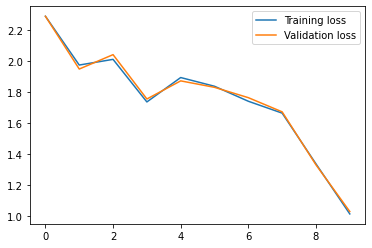

In [74]:
torch.manual_seed(42)
gc.collect()
torch.cuda.empty_cache()
models = [
    (train(DensePolyNN, config, (train_x, train_y, val_x, val_y)), 'DensePolyNN'),
    # (train(DenseLinearNN, config, train_x, train_y, val_x, val_y), 'DenseLinearNN'),
    # (train(SimpleCNN, config, (train_x, train_y, val_x, val_y)), 'SimpleCNN'),
]
gc.collect()
torch.cuda.empty_cache()

## Test Model

In [76]:
logging.info('Generating predictions and calculating accuracy')
print(test_x)
print(test_y)
for model, tag in models:
    accuracy = test(model, test_x, test_y)
    logging.info(f'{tag}: {accuracy=}')

03:01:35 INFO: Generating predictions and calculating accuracy
03:01:35 INFO: DensePolyNN: accuracy=0.622


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.